In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



excel_file='Waste_arima.xlsx'
waste_data=pd.read_excel(excel_file, parse_dates=["Date"], index_col="Date")
waste_data.head()

,Food Waste,Plastic Waste,Solid Waste,Total
Date,,,,
2018-01-01,266.5,85.0,0.0,351.5
2018-01-02,216.3,76.6,0.0,292.9
2018-01-03,219.3,98.0,0.0,317.3
2018-01-04,222.7,90.0,2.0,314.7
2018-01-05,220.0,106.5,0.0,326.5


In [0]:
waste_data.dtypes


Food Waste       float64
Plastic Waste    float64
Solid Waste      float64
 Total           float64
dtype: object

In [0]:
#space after food waste
food=waste_data["Food Waste"]
food.head()

Date
2018-01-01    266.5
2018-01-02    216.3
2018-01-03    219.3
2018-01-04    222.7
2018-01-05    220.0
Name: Food Waste, dtype: float64

In [0]:

from datetime import datetime
food[datetime(2018,1,2)]


216.3

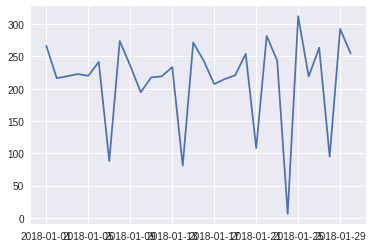

In [0]:
plt.plot(food)

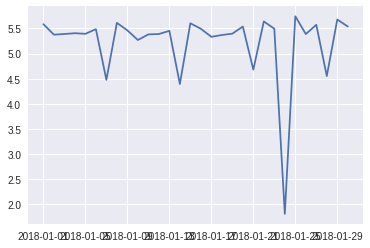

In [0]:
#overall slow increasing trend with instat pitfalls
#to make time series stationary check trend and seasonality
# trend:  varying mean over time. overall waste increases
# seasonality: variations at specific time-frames. people produce low waste during a particular day


#estimating trend - reduce trend by applying log,root,cuberoot function
#log penalises higher changes
food_log=np.log(food)
plt.plot(food_log)

In [0]:
#dickey fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

SyntaxError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()
  import sys


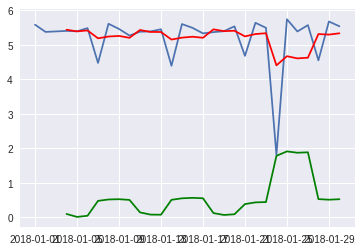

In [0]:
# estimating trend
#moving average or rolling means

food_rolling_mean=pd.rolling_mean(food_log,4)
plt.plot(food_log)
plt.plot(food_rolling_mean, color='red')

#food_std = food_log - food_rolling_mean
food_std=pd.rolling_std(food_log,4)
#food_std.dropna(inplace=True)
plt.plot(food_std, color="green")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=4,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


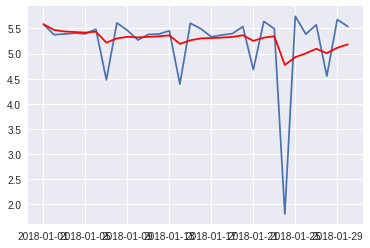

In [0]:
#exponential average
expwighted_avg = pd.ewma(food_log, halflife=4)
plt.plot(food_log)
plt.plot(expwighted_avg, color='red')
expwighted_avg_diff= food_log-expwighted_avg
#expwighted_avg_diff
#plt.plot(expwighted_avg_diff, color="green")

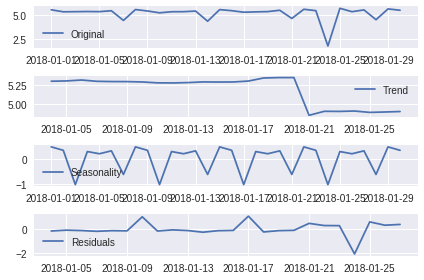

In [0]:
#eliminating trend and seasonality with decomposition 
#makes model stationary

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(food_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(food_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

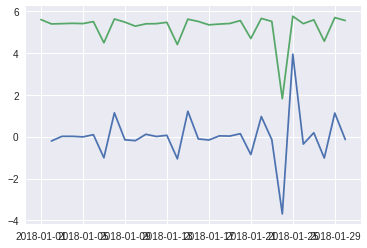

In [0]:
#diiferenceing

food_log_diff = food_log - food_log.shift(1)
food_log_diff.dropna(inplace=True)
plt.plot(food_log_diff)
plt.plot(food_log)

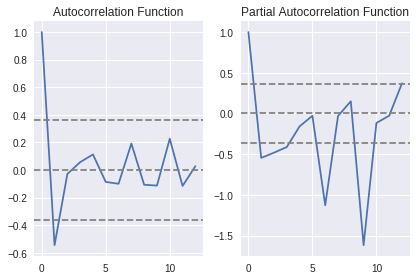

In [0]:
#forecasting a time series

#ARIMA : ARIMAA(p,d,q)
#p : The lag value where the PACF chart crosses the upper confidence interval or upper boundary for the first time.
#q : The lag value where the ACF chart crosses the upper confidence interval for the first time. 



#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(food_log_diff, nlags=12)
lag_pacf = pacf(food_log_diff, nlags=12, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(food_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(food_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(food_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(food_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated

Text(0.5, 1.0, 'RSS: 12.8073')

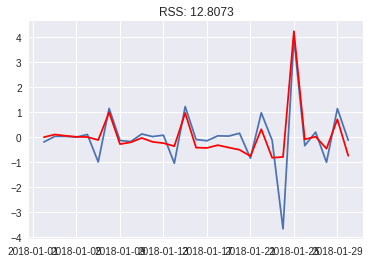

In [0]:
# p=5 d=1 q=1

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(food_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(food_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-food_log_diff)**2))


In [0]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


#cumulative sum taken and then added with base value
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())



Date
2018-01-02   -0.016024
2018-01-03    0.090385
2018-01-04    0.039152
2018-01-05   -0.001125
2018-01-06   -0.010246
dtype: float64
Date
2018-01-02   -0.016024
2018-01-03    0.074360
2018-01-04    0.113512
2018-01-05    0.112386
2018-01-06    0.102141
dtype: float64


In [0]:
predictions_ARIMA_log = pd.Series(food_log.ix[0], index=food_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2018-01-01    5.585374
2018-01-02    5.569350
2018-01-03    5.659734
2018-01-04    5.698886
2018-01-05    5.697761
dtype: float64

Text(0.5, 1.0, 'RMSE: 154.0719')

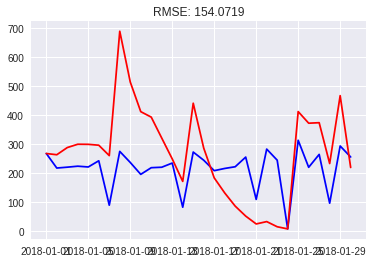

In [0]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(food ,color="blue")
plt.plot(predictions_ARIMA, color="red")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-food)**2)/len(food)))



In [0]:
predictions_ARIMA.head()

Date
2018-01-01    266.500000
2018-01-02    262.263534
2018-01-03    287.072384
2018-01-04    298.534659
2018-01-05    298.198891
dtype: float64

In [0]:
food.head()

Date
2018-01-01    266.5
2018-01-02    216.3
2018-01-03    219.3
2018-01-04    222.7
2018-01-05    220.0
Name: Food Waste, dtype: float64